In [47]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from TreeDataset import TreeDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import detectors
import timm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from utils.helperFunctions import create_search_run, save_best_hyperparam
from torch.optim import Adam, AdamW, SGD, Adamax, Adagrad, RMSprop, Adadelta
from experimental_models import ResNetModified, FullyConnectedNetwork, ResNetExtended

labels = np.load('dataset/train_dataset.npz', allow_pickle=True)["labels"]
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

train_raw = np.load("dataset/train_dataset.npz", allow_pickle=True)
X_train = train_raw["data"]
y_train = train_raw["labels"]
y_test = LabelEncoder().fit_transform(y_train)

test_raw = np.load("dataset/test_dataset.npz", allow_pickle=True)
X_test = test_raw["data"]
y_test = test_raw["labels"]
print(type(y_test))

y_test = LabelEncoder().fit_transform(y_test)

train_dataset = TreeDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, 32, shuffle=False, drop_last=True)


test_dataset = TreeDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, 32, shuffle=False, drop_last=True)

len(train_dataset.data)

<class 'numpy.ndarray'>


9393

In [ ]:
search_folder = create_search_run()

model = ResNetExtended(30)

class_counts = np.bincount(train_dataset.labels)
total_samples = len(train_dataset)
class_weights = 1.0 / (class_counts/ total_samples)
# Learning parameters.

# Loss function. Required for defining `NeuralNetClassifier`
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float())
optim = [Adam, AdamW, SGD, Adamax, Adagrad]

# Instance of `NeuralNetClassifier` to be passed to `GridSearchCV` 
net = NeuralNetClassifier(
    module=model,
    criterion=criterion,
    max_epochs=50,
    optimizer=Adam,
    verbose=1
)

# 
params = {
    'batch_size': [32],
    'optimizer__lr': [0.0001, 0.00001, 0.000001, 0.0000001]
}

"""
Define `GridSearchCV`.
4 lrs * 7 max_epochs * 4 module__first_conv_out * 3 module__first_fc_out
* 2 CVs = 672 fits.
"""
gs = GridSearchCV(
    net, params, refit=False, scoring='f1_weighted', cv=2, verbose=2
)

counter = 0
# Run each fit for 2 batches. So, if we have `n` fits, then it will
# actually for `n*2` times. We have 672 fits, so total, 
# 672 * 2 = 1344 runs.
search_batches = 2
"""
This will run `n` (`n` is calculated from `params`) number of fits 
on each batch of data, so be careful.
If you want to run the `n` number of fits just once, 
that is, on one batch of data,
add `break` after this line:
    `outputs = gs.fit(image, labels)`

Note: This will take a lot of time to run
"""
for i, data in enumerate(train_loader):
    counter += 1
    image, labels = data
    # image = image.to(device)
    # labels = labels.to(device)
    outputs = gs.fit(image.float(), labels.long())
    # GridSearch for `search_batches` number of times.
    if counter == search_batches:
        break

print('SEARCH COMPLETE')
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))
save_best_hyperparam(gs.best_score_, f"{search_folder}/best_param.yml")
save_best_hyperparam(gs.best_params_, f"{search_folder}/best_param.yml")

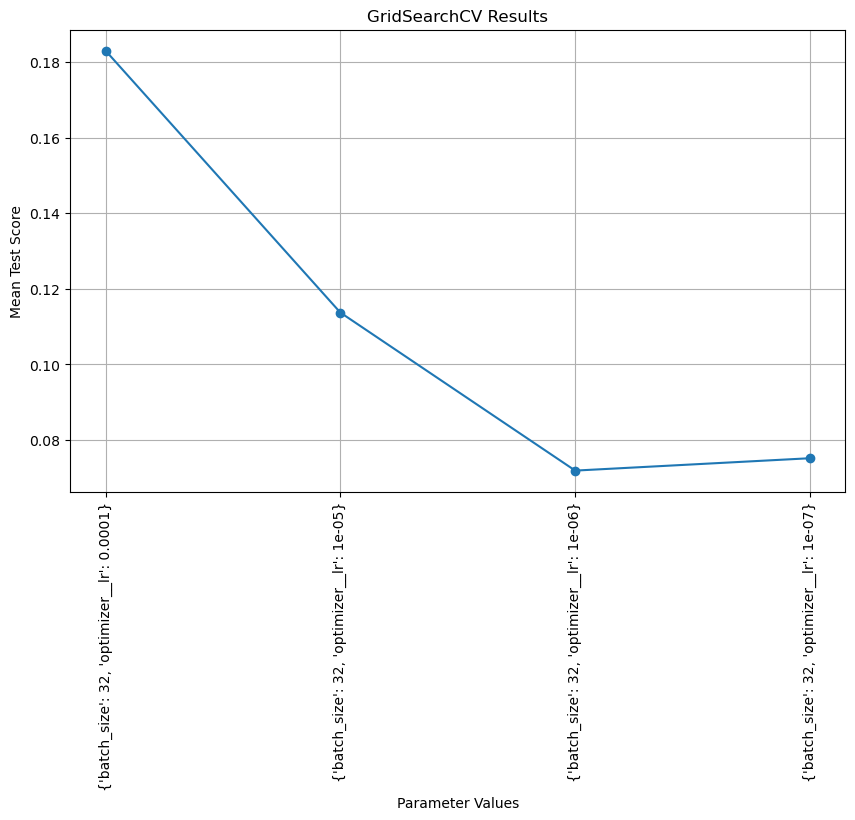

In [44]:
grid_results = gs.cv_results_
params = grid_results['params']
mean_scores = grid_results['mean_test_score']

# Extract the parameter values and scores
param_values = [str(param) for param in params]
scores = np.array(mean_scores).reshape(len(param_values))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(param_values, scores, marker='o')
plt.xlabel('Parameter Values')
plt.ylabel('Mean Test Score')
plt.title('GridSearchCV Results')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

[       nan        nan        nan        nan        nan 0.04377104
 0.00606061 0.00757576 0.         0.02222222]


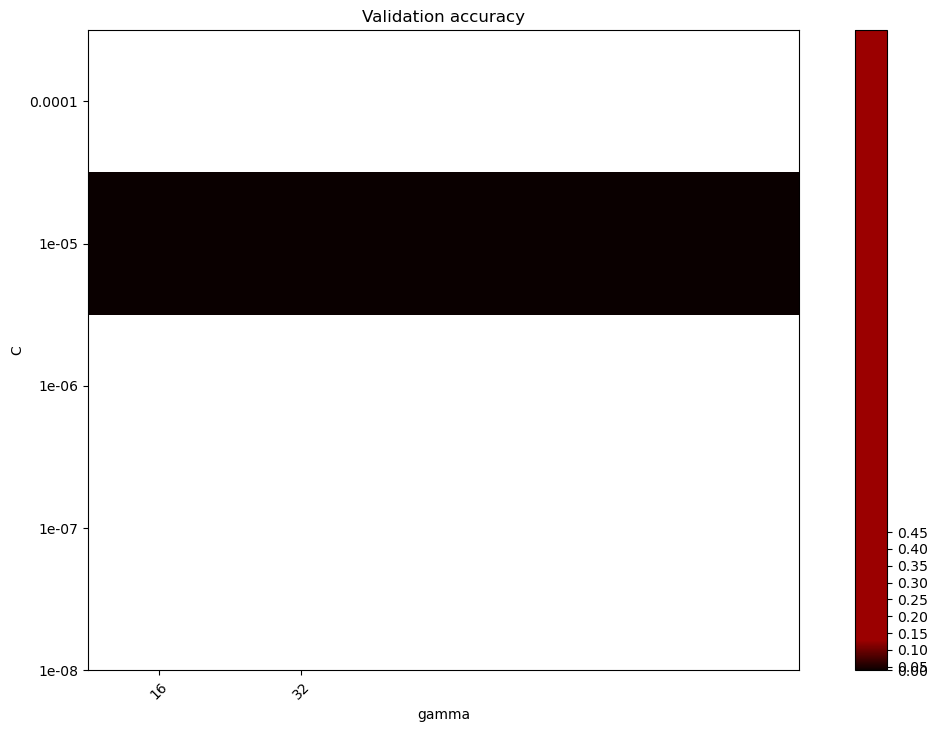

In [16]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

scores = gs.cv_results_["mean_test_score"].reshape(len(params['batch_size']), len(params['optimizer__lr']))

print(gs.cv_results_["mean_test_score"])
plt.figure(figsize=(15, 8))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.45, midpoint=0.99),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(params['batch_size'])), params['batch_size'], rotation=45)
plt.yticks(np.arange(len(params['optimizer__lr'])), params['optimizer__lr'])
plt.title("Validation accuracy")
plt.show()

In [38]:
base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
class AdjustedModel(nn.Module):
    def __init__(self, in_features):
        super(AdjustedModel, self).__init__()
        self.preprocessing_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=64,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=128, out_channels=3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='nearest')
        )
        self.base_model = base_model
        self.postprocessing_layer = nn.Linear(base_model.fc.out_features, 10)

    def forward(self,x):
        x = self.preprocessing_layer(x)
        x = self.base_model(x)
        x = self.postprocessing_layer(x)
        return x

model = AdjustedModel(30)
# model = FullyConnectedNetwork(5,30,0.3,10)
model.load_state_dict(torch.load("resnet50_model_20230717_183329_79"))
print(model)

model.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
label_collector = []
prediction_collector = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        label_collector.append(labels)
        prediction_collector.append(predicted)
print(
    f'Accuracy of the network on the test images: {100 * correct // total} %')



<class 'numpy.ndarray'>


c:\Users\USER\anaconda3\envs\DSEO_project\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(

KeyboardInterrupt



In [ ]:
from sklearn.metrics import average_precision_score

predictions = le.inverse_transform(torch.cat(prediction_collector))
labels = le.inverse_transform(torch.cat(label_collector))

cm = confusion_matrix(labels, predictions)

ConfusionMatrixDisplay(cm).plot()


In [36]:
from sklearn.metrics import f1_score

f1_scores = f1_score(labels, predictions, average='weighted')

print(f1_scores*100)

# f1_scores = {}

# for classes in labels:
#     y_true = 
#     f1_scores[classes] = f1_score()

1.6489626437081122


In [48]:
le_name_mapping = dict(zip(le.classes_, le.inverse_transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [45]:
from torchinfo import summary

model = ResNetExtended(30)

summary(model, input_size = (32,30,5,5))

Layer (type:depth-idx)                        Output Shape              Param #
ResNetExtended                                [32, 10]                  --
├─Sequential: 1-1                             [32, 3, 20, 20]           --
│    └─Conv2d: 2-1                            [32, 3, 5, 5]             813
│    └─BatchNorm2d: 2-2                       [32, 3, 5, 5]             6
│    └─ReLU: 2-3                              [32, 3, 5, 5]             --
│    └─Upsample: 2-4                          [32, 3, 20, 20]           --
├─ResNet: 1-2                                 [32, 10]                  --
│    └─Conv2d: 2-5                            [32, 64, 10, 10]          (9,408)
│    └─BatchNorm2d: 2-6                       [32, 64, 10, 10]          (128)
│    └─ReLU: 2-7                              [32, 64, 10, 10]          --
│    └─MaxPool2d: 2-8                         [32, 64, 5, 5]            --
│    └─Sequential: 2-9                        [32, 256, 5, 5]           --
│    │    └─